## Introduction

This material was prepared by **Danie Benetton**.

Project financially supported by the University of British Columbia, Department of Chemical and Biological Engineering (CBHE).

August 2020

This Jupyter Notebook is an overview of the functions for single PDE solutions using FiPy package that are used in CHBE coursework.

## Instructions
**Preferred method:**

To use this notebook, make sure Anaconda is installed [Link to Download](https://www.anaconda.com/products/individual)

This tutorial is best run in **JupyterLab.** [JupyterLab Introduction Video](https://www.youtube.com/watch?v=A5YyoCKxEOU). 

Ensure that you have the JupyterLab extension "@jupyterlab/toc" installed to navigate this document. This can be easily installed through the Extension Manager.

**Alternative method:**

UBC students and professors can also access this notebook through [Syzygy](https://ubc.syzygy.ca/). Log in with your CWL, upload this notebook to your files, and run the notebook.

## Installing the FiPy Library

For this notebook, the installation of the **FiPy library is required.** Installation instructions, as well as general information about the library, can be found [in the documentation.](https://www.ctcms.nist.gov/fipy/INSTALLATION.html)

The **simplest method** is to run the following command in the Anaconda prompt: `conda install -c conda-forge fipy`

There are other libraries that will be needed for the use of the FiPy library, most of which are likely already installed. These include:
- NumPy
- SciPy
- matplotlib

## Matplotlib settings

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update({'mathtext.fontset': 'cm'})
mpl.rcParams.update({'axes.labelsize': 22})
mpl.rcParams.update({'axes.titlesize': 16})
mpl.rcParams.update({'axes.linewidth': 0.5})
mpl.rcParams.update({'xtick.labelsize': 10})
mpl.rcParams.update({'ytick.labelsize': 10})
%config InlineBackend.figure_formats = ['svg']

# Intro to FiPy

FiPy is one of many numerical solvers for PDEs. This package uses a finite volume approach. This is a discretization method that transforms the problem domain into a set of control volumes, over which balance equations are solved. 

More detail on the theory behind the **numerical solution approach** can be found at [this link.](https://www.ctcms.nist.gov/fipy/documentation/numerical/index.html)

This package is selected for this notebook for several reasons:
* support for Linux, MacOS, and Windows platforms, so code can be shared easily
* publicly available software with no license required
* high level implementation that allows for customizable solution parameters

## Main Python Classes

Before solving a PDE using FiPy, we must first take a look at the objects that make up FiPy.

* *Mesh* object: the domain of interest.
* *Variable* object: a variable or field that can change throughout the problem's solution. The value can be a scalar or a dependancy relationship on another variabe. The value is not calculated until it is needed. 
* *Term* object: a term in the conservation equation including transient, convection, diffusion, source, or any linear combination of these.



## FiPy Governing Equation

The general conservation equation in FiPy is as follows:

<p style="text-align:center;">
<img src="images/FiPyEquation.png" width=400>
</p>

All terms in the PDE to solve must fit one of these terms or a linear combination thereof. 

A full description of the equation is found [here.](https://www.ctcms.nist.gov/fipy/documentation/numerical/equation.html) More information on how to represent equations in FiPy is found [here.](https://www.ctcms.nist.gov/fipy/documentation/FAQ.html#how-do-i-represent-an-equation-in-fipy)

## Note on Numerix

**Numerix** is a submodule of FiPy that retains all of the functionality of NumPy, and adds several functions of use when solving PDEs in FiPy. The documentation for Numerix can be found [here.](https://www.ctcms.nist.gov/fipy/fipy/generated/fipy.tools.html#module-fipy.tools.numerix)
> Since this module imports NumPy, it is **not** recommended to import NumPy in your own scripts  

The functions in Numerix work with *Variables*, arrays, and numbers. If a Numerix function is performed on a *Variable*, the returned value will also be a *Variable*.

In [2]:
from fipy.variables.variable import Variable
from fipy.tools import numerix

var = Variable(value=0)

v = numerix.tan(var)
v

tan(Variable(value=array(0)))

# Example: Heat Equation

Find a solution to the heat equation representing the temperature distribution in a bar.

$$\frac{\partial \phi}{\partial t} = D \frac{\partial^2 \phi}{\partial x^2}$$

with the conditions:
* $D = 1$
* $\phi (x,0) = 6\sin{\frac{\pi x}{L}}$
* $\phi (0,t) = 0$
* $\phi (L,t) = 0$

The analytical solution of this problem is $\phi (x,t) = 6\sin{\frac{\pi x}{L}}e^{-D(\frac{\pi}{L})^2t}$

Some features of this problem:
* 1D diffusion with constant diffusivity
* fixed boundary conditions
* location-dependent initial conditions

For a similar example, see [the example in FiPy documentation.](https://www.ctcms.nist.gov/fipy/examples/diffusion/generated/examples.diffusion.mesh1D.html)

**Solution:**

In the following cell, we set up the problem including mesh, variables, initial and boundary conditions. To confirm conditions, we plot the temperature distribution at $t = 0$.

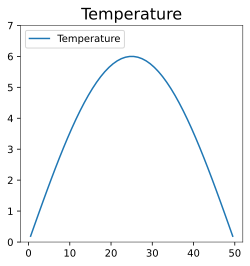

In [3]:
from fipy import Variable, FaceVariable, CellVariable, Grid1D, ExplicitDiffusionTerm, TransientTerm, DiffusionTerm, Viewer
from fipy.tools import numerix

# Defining one dimensional domain
nx = 50
dx = 1.
mesh = Grid1D(nx=nx, dx=dx)

# Define length of bar and variable for relative length
L = nx * dx
x = mesh.cellCenters[0]

# Defining the solution variable with initial condition
phi = CellVariable(name="Temperature",
                    mesh=mesh,
                    value=6*numerix.sin(numerix.pi*x/L))

# Set diffusion coefficient to 1
D = 1.

# Boundary conditions
valueLeft = 0
valueRight = 0
phi.constrain(valueRight, mesh.facesRight)
phi.constrain(valueLeft, mesh.facesLeft)

# View the temperature distribution at t=0 to confirm initial condition
viewer = Viewer(vars = (phi,), datamin = 0, datamax = 7)

Next, the equation is defined with the built-in terms as follows: 


`TransientTerm()` = $\frac{\partial \phi}{\partial t}$  
`ExplicitDiffusionTerm(coeff = D)` = $D \frac{\partial^2 \phi}{\partial x^2}$

> Further explanation of *Terms* may be found [here.](https://www.ctcms.nist.gov/fipy/documentation/numerical/discret.html#section-discretization)

Time steps are defined to meet the stability criterion: $\Delta t \leq \frac{\Delta x^2}{2D}$. To ensure stability, we take the time step as 90% of this value.

In [4]:
# Define PDE
eqX = TransientTerm() == ExplicitDiffusionTerm(coeff=D)

# Define time steps to meet stability criterion
timeStepDuration = 0.9 * dx**2 / (2 * D)
steps = 100

As we know the analytical solution of this problem with the specified initial conditions, we would like to define it to compare the results.

In [5]:
phiAnalytical = CellVariable(name="Analytical Value", mesh=mesh)

t = timeStepDuration * steps
print('Time to compare (s):', t)

phiAnalytical.setValue(6*numerix.sin(numerix.pi*x/L)*numerix.exp(-D*t*(numerix.pi/L)**2))

Time to compare (s): 45.0


Solving the PDE over the specified time range.

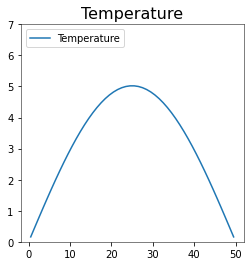

<Figure size 432x288 with 0 Axes>

In [6]:
from builtins import range
for step in range(steps):
    eqX.solve(var=phi,
        dt=timeStepDuration)
    viewer.plot()

Now we compare the analytical solution and the numerical solution for the final time point. As can be seen in the graph below, the answers match.

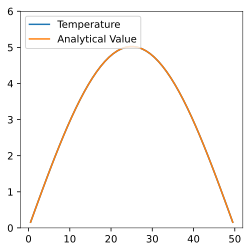

In [7]:
viewer = Viewer(vars=(phi, phiAnalytical), datamin = 0, datamax = 6)

# Example: Diffusion with Insulation Boundary Condition

A wall $0.12 m$ thick having a thermal diffusivity of $1.5 \times 10^{-6} m^2/s$ is initially at a uniform temperature of $85 \deg C$. Suddenly the right face is lowered to a temperature of $20 \deg C$, while the left face is perfectly insulated. Using space and time increments of $30 mm$ and $300 s$, respectively, determine the temperature distribution at $t = 45 min$.

**Solution:**

This example is very similar to that of the heat equation above, with the noted difference of a more complex boundary condition. The different boundary conditions available in FiPy and how to define them are found [here.](https://www.ctcms.nist.gov/fipy/documentation/USAGE.html#boundary-conditions)

The units that will be used in the solver are meteres and seconds to keep units consistent with the diffusivity constant. The time increment of 300 seconds meets the stability criterion.

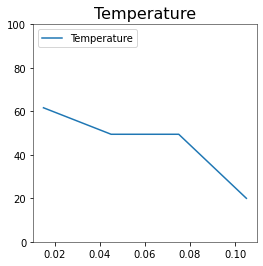

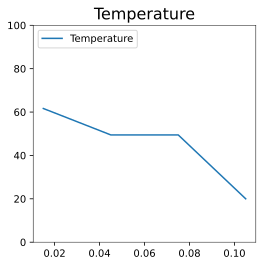

In [8]:
from fipy import Variable, FaceVariable, CellVariable, Grid1D, ExplicitDiffusionTerm, TransientTerm, DiffusionTerm, Viewer
from fipy.tools import numerix

# Defining one dimensional domain
nx = 4
dx = 0.03
mesh = Grid1D(nx=nx, dx=dx)

# Define length of bar and variable for relative length
L = nx * dx
print('Length in meters:', L)

# Defining the solution variable with initial condition
phi = CellVariable(name="Temperature",
                    mesh=mesh,
                    value=85.)

# Set diffusion coefficient to 1
D = 1.5e-6

# Boundary conditions
valueLeft = 0
valueRight = 20
phi.constrain(valueRight, mesh.facesRight)
phi.faceGrad.constrain(valueLeft, mesh.facesLeft)

# View the temperature distribution at t=0 to confirm initial condition
viewer = Viewer(vars = (phi,), datamin = 0, datamax = 100)

# Define PDE
eqX = TransientTerm() == ExplicitDiffusionTerm(coeff=D)

# Define time steps to meet stability criterion
timeStepDuration = 1 * dx**2 / (2 * D)

steps = 9
t = timeStepDuration * steps / 60
print('Time to compare (min):', t)

from builtins import range
for step in range(steps):
    eqX.solve(var=phi,
        dt=timeStepDuration)
    viewer.plot()

Below is data from manually computing the finite-difference solution using the same space and time increments. Plot size and axes have been edited for comparison to FiPy output.

As can be seen, the end points have similar values, but the interior points are not close due to the small number of mesh points and inaccuracy of the manually computed solution.

> **Note**: For a more accurate result, a higher number of mesh points is recommended

(0.0, 100.0)

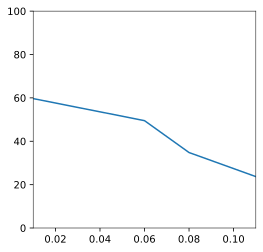

In [9]:
import matplotlib.pyplot as plt

analytical = numerix.array([[0, 0.03, 0.06, 0.08, 0.12],[61.7, 55.6, 49.5, 34.8, 20]])

plt.figure(figsize=[4, 4])
plt.plot(analytical[0], analytical[1])
plt.xlim(0.01, 0.11)
plt.ylim(0, 100)

# Example: 1D Convection-Diffusion

Consider 1D, steady-state flow of water through a constant cross-sectional area, 1m long pipe. A chemical is injected along the length of the pipe by a constant source.

The steady state convection-diffusion equation with source is as follows:

$$
\nabla (D \nabla c + \vec{v} c) + S_0 = 0
$$

Find the concentration profile of this system with the diffusivity constant $D = 3.0 m^2/s $, the velocity of the water $\vec{v} = 2.0 m/s$ and the source $S_0 = 1.0 kg(sL)^{-1}$. Assume incompressible flow, constant diffusion coefficient, and no reactions.

Some features of this problem:
* steady state
* fixed boundary conditions
* constant source term

True


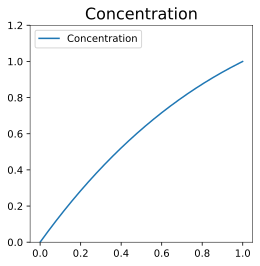

In [10]:
from fipy import CellVariable, Grid1D, DiffusionTerm, ExponentialConvectionTerm, DefaultAsymmetricSolver, Viewer
from fipy.tools import numerix

diffCoeff = 3.0
convCoeff = (2.0,)
sourceCoeff = 1.0

# Defining mesh
nx = 1000
L = 1.
mesh = Grid1D(dx= L / 1000, nx=nx)

# Defining boundary conditions
valueLeft = 0.
valueRight = 1.

var = CellVariable(name="Concentration", mesh=mesh)

var.constrain(valueLeft, mesh.facesLeft)
var.constrain(valueRight, mesh.facesRight)

# Defining equation

eq = (DiffusionTerm(coeff=diffCoeff) + ExponentialConvectionTerm(coeff=convCoeff) + sourceCoeff)

eq.solve(var=var, solver=DefaultAsymmetricSolver(tolerance=1.e-15, iterations=10000))


axis = 0
x = mesh.cellCenters[axis]
AA = -sourceCoeff * x / convCoeff[axis]
BB = 1. + sourceCoeff * L / convCoeff[axis]
CC = 1. - numerix.exp(-convCoeff[axis] * x / diffCoeff)
DD = 1. - numerix.exp(-convCoeff[axis] * L / diffCoeff)
analyticalArray = AA + BB * CC / DD
print(var.allclose(analyticalArray, rtol=1e-4, atol=1e-4))

# View the concentration profile
viewer = Viewer(vars=var, datamin = 0, datamax = 1.2)

# Example: 2D Temperature Distribution

Functionally graded materials are intentionally fabricated to establish a spatial distribution of properties in the final product. Consider an  $ L \times L $ two-dimensional object with $L = 20 mm$. The thermal conductivity distribution of the functionally graded material is $k(x) =  20 W/m \cdot K + (7070 W/m^{5/2}\cdot K)x^{3/2}$.

<p style="text-align:center;">
<img src="images/2Dconduction.png" width=500>
</p>
 Apply the following set of boundary conditions:
 
| Surface  | Condition  |
|---|---|
| 1  | T = 100 °C  |
|  2 | T = 50 °C  |
| 3  |  Adiabatic |
| 4  |  Adiabatic |

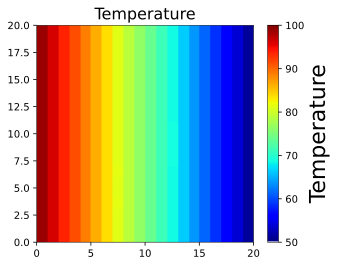

In [11]:
from fipy import CellVariable, Grid2D, Viewer, TransientTerm, DiffusionTerm
from fipy.tools import numerix

# Defining mesh
nx = 20
ny = nx
dx = 1.
dy = dx
L = dx * nx
mesh = Grid2D(dx=dx, dy=dy, nx=nx, ny=ny)

# Define solution variable
phi = CellVariable(name = "Temperature", mesh = mesh)

# Defining the thermal conductivity
D = FaceVariable(mesh=mesh)
X = mesh.faceCenters[0]
D.setValue(20+7070*(X/1000)**(3/2))

eq = DiffusionTerm(coeff=D)

# Boundary conditions - non defined sides have Neumann conditions applied by default
valueLeft = 100
valueRight = 50
phi.constrain(valueLeft, mesh.facesLeft)
phi.constrain(valueRight, mesh.facesRight)

# Solving the steady state equation
DiffusionTerm().solve(var=phi)

viewer = Viewer(vars=phi, datamin=50., datamax=100.)

As you can see from the graph, since Surfaces 3 and 4 are adiabatic and the thermal conductivity varies only in the x direction, this is really a 1D problem masquerading as a 2D problem. A manually derived numerical solution for the temperature gradient with the same spatial increments is plotted below for validation.

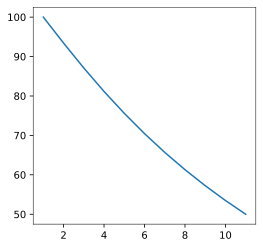

In [12]:
import matplotlib.pyplot as plt

analytical = numerix.array([[1,2,3,4,5,6,7,8,9,10,11],[100,93.41,87.09,81.14,75.6,70.45,65.69,61.3,57.24,53.48,50.]])

plt.figure(figsize=[4, 4])
plt.plot(analytical[0], analytical[1])

# Further Reading and Examples

1. [FiPy Manual](https://www.ctcms.nist.gov/fipy/download/fipy-3.1.pdf): Full descriptions of all functions and objects in FiPy
2. [1D Diffusion in Semi-Infinite Domain](https://www.ctcms.nist.gov/fipy/examples/diffusion/generated/examples.diffusion.mesh1D.html): Implicit and explicit diffusion terms. Also demonstrates spatially varying diffusion coefficient.
3. [Diffusion Circle](https://www.ctcms.nist.gov/fipy/examples/diffusion/generated/examples.diffusion.circle.html): Transient diffusion in a circular domain. 

# References

1. T. L. Bergman, A. S. Lavine, et. al, *Fundamentals of Heat and Mass Transfer*, 8th ed. Hoboken, NJ: John Wiley & Sons, 2017.